### Mounting google drive folder


In [1]:
# This mounts your Google Drive to the Colab VM.
from google.colab import drive
drive.mount('/content/drive')


FOLDERNAME = "ENPM809K/final project/"
assert FOLDERNAME is not None, "[!] Enter the foldername."

# Now that we've mounted your Drive, this ensures that
# the Python interpreter of the Colab VM can load
# python files from within it.
import sys
sys.path.append('/content/drive/My Drive/{}'.format(FOLDERNAME))

%cd /content/drive/My\ Drive/$FOLDERNAME

Mounted at /content/drive
/content/drive/My Drive/ENPM809K/final project


In [2]:
!pip install transformers

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import transformers
import torch
import seaborn as sns

# pytorch imports
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 5.8 MB 7.1 MB/s 
     |████████████████████████████████| 182 kB 78.1 MB/s 
     |████████████████████████████████| 7.6 MB 42.0 MB/s 


In [3]:
%matplotlib inline
%config InlineBackend.figure_format='retina'
sns.set(style='whitegrid', palette='muted', font_scale=1.2)

### Loading datasets from CSV file

In [4]:
train_df = pd.read_csv("data/train_data.csv")
test_df = pd.read_csv("data/test_data.csv")

### Reducing dataset size for faster results

In [5]:
train_df = train_df.iloc[:500000]
test_df = test_df.iloc[:100000]

In [6]:
train_df.shape

(500000, 2)

In [7]:
train_df.head()

,reviews,labels
0,stuning even for the non-gamer: this sound tra...,1
1,the best soundtrack ever to anything.: i'm rea...,1
2,amazing!: this soundtrack is my favorite music...,1
3,excellent soundtrack: i truly like this soundt...,1
4,"remember, pull your jaw off the floor after he...",1


In [8]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 500000 entries, 0 to 499999
Data columns (total 2 columns):
 #   Column   Non-Null Count   Dtype 
---  ------   --------------   ----- 
 0   reviews  500000 non-null  object
 1   labels   500000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 7.6+ MB


### Plotting sentiment counts for train and test datasets

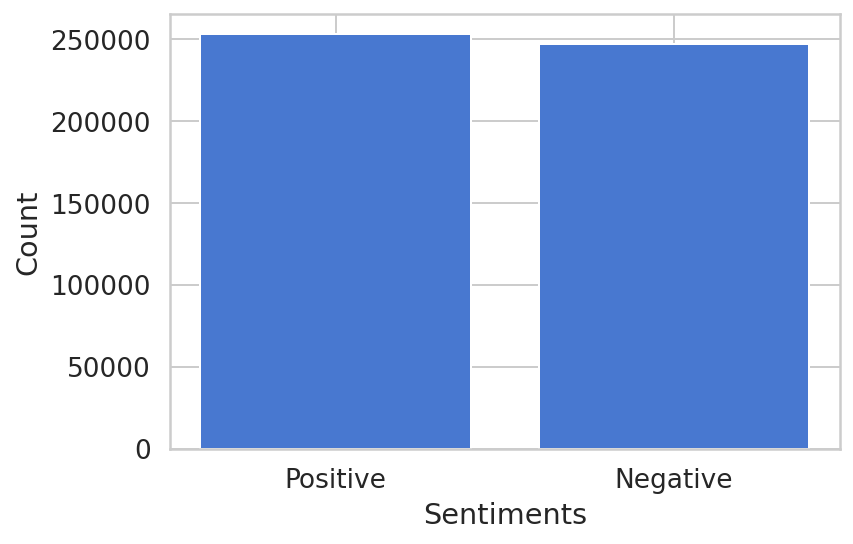

In [ ]:
val_count = train_df['labels'].value_counts()
plt.bar(['Positive', 'Negative'], val_count.values, width=0.8)
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.show()

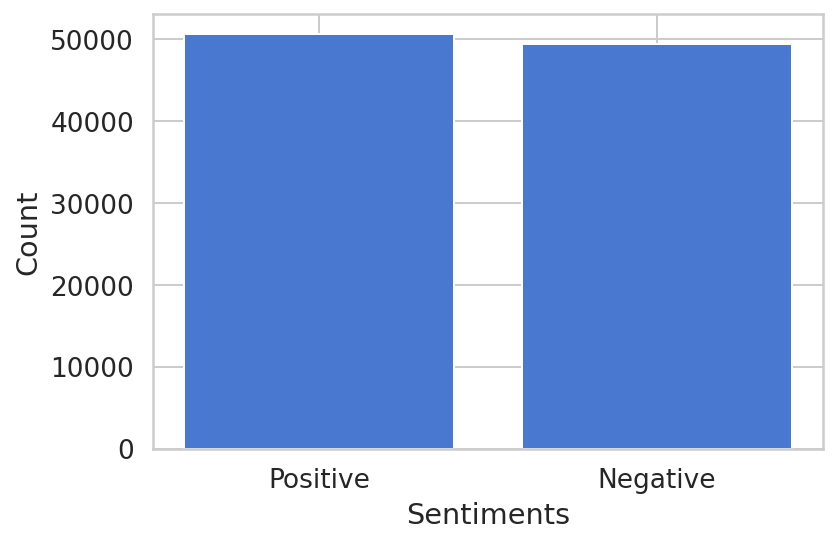

In [ ]:
val_count = test_df['labels'].value_counts()
plt.bar(['Positive', 'Negative'], val_count.values, width=0.8)
plt.xlabel('Sentiments')
plt.ylabel('Count')
plt.show()

### Splitting datasets to Train, Validation, Test

In [9]:
from sklearn.model_selection import train_test_split

In [10]:
x_train, x_val, y_train, y_val = train_test_split(train_df.reviews, train_df.labels, test_size=0.3, random_state=42)
x_test, y_test = test_df.reviews, test_df.labels
print("Train dataset size: {}; Validation dataset size: {}; Test dataset size {}".format(x_train.shape, x_val.shape, x_test.shape))

Train dataset size: (350000,); Validation dataset size: (150000,); Test dataset size (100000,)


In [11]:
x_train, x_val, y_train, y_val = x_train.to_numpy(), x_val.to_numpy(), y_train.to_numpy(), y_val.to_numpy()
x_test, y_test = x_test.to_numpy(), y_test.to_numpy()

### BERT model implementation

In [ ]:
tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-cased")

# experimented with different tokenizers
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-large-cased")
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-large-uncased")
# tokenizer = transformers.BertTokenizer.from_pretrained("bert-base-uncased")

Understanding tokenizer

1. Tokens

In [ ]:
sample_txt = x_train[0][:100]
tokens = tokenizer.tokenize(sample_txt)
token_ids = tokenizer.convert_tokens_to_ids(tokens)

print("Sample text: {}".format(sample_txt))
print("Text Tokens: {}".format(tokens))
print("Text Tokens IDs: {}".format(token_ids))

Sample text: great book: when i first read this book 00 years ago, i was all of 00 years old. i'd never really be
Text Tokens: ['great', 'book', ':', 'when', 'i', 'first', 'read', 'this', 'book', '00', 'years', 'ago', ',', 'i', 'was', 'all', 'of', '00', 'years', 'old', '.', 'i', "'", 'd', 'never', 'really', 'be']
Text Tokens IDs: [1632, 1520, 131, 1165, 178, 1148, 2373, 1142, 1520, 3135, 1201, 2403, 117, 178, 1108, 1155, 1104, 3135, 1201, 1385, 119, 178, 112, 173, 1309, 1541, 1129]


2. Special Tokens

In [ ]:
print("Separator Token: {} Token ID: {}".format(tokenizer.sep_token, tokenizer.sep_token_id))
print("Class Token: {} Token ID: {}".format(tokenizer.cls_token, tokenizer.cls_token_id))
print("Padding Token: {} Token ID: {}".format(tokenizer.pad_token, tokenizer.pad_token_id))
print("Unknown Token: {} Token ID: {}".format(tokenizer.unk_token, tokenizer.unk_token_id))

Separator Token: [SEP] Token ID: 102
Class Token: [CLS] Token ID: 101
Padding Token: [PAD] Token ID: 0
Unknown Token: [UNK] Token ID: 100


In [ ]:
# encoding sample text -> adding special tokens
encoding = tokenizer.encode_plus(
    sample_txt,
    max_length = 200,
    add_special_tokens = True, # adds special tokens to encoded text
    padding = 'max_length',
    return_attention_mask = True, # returns attention mask for the text
    return_token_type_ids = False,
    return_tensors = 'pt' # return encoded string as tensors
)
print("Encoded Text")
print(encoding['input_ids'])
print("Attention mask for encoded text -> 1 for word tokens, 0 for padding tokens")
print(encoding['attention_mask'])

Encoded Text
tensor([[ 101, 1632, 1520,  131, 1165,  178, 1148, 2373, 1142, 1520, 3135, 1201,
         2403,  117,  178, 1108, 1155, 1104, 3135, 1201, 1385,  119,  178,  112,
          173, 1309, 1541, 1129,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0, 

### Choosing sequence max length

In [ ]:
max_len = 0
for text in x_train:
  length = len(text)
  if length > max_len:
    max_len = length

print("Reviews max length :", max_len)

Reviews max length : 1015


For faster training lets limit the seq len to 512

### Creating custom data loader

In [16]:
from bert.bert_utils import ReviewsDataset

Implementation can be found in bert_utils.py

In [17]:
ds = ReviewsDataset(x_train, y_train, tokenizer, max_len=128)

In [ ]:
ds[7]['encoding']

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(


tensor([  101,  1353,   131,  1122,  1110,  1304,  1353,  1105, 14756,  6505,
          119,   178,  1274,   112,   189,  1256,  1221,  1184,  1106,  1202,
         1114,  1122,   117,   178,  1198,  1508,  1122,  1283,  1165,  1122,
         1338,   119,   102,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
            0,     0,     0,     0,     0,     0,     0,     0])

In [18]:
def bert_data_loader(x, y, tokenizer, max_len, batch_size):
  dataset = ReviewsDataset(x, y, tokenizer, max_len)
  data_loader = DataLoader(dataset, batch_size=batch_size, num_workers=2)
  return data_loader

In [19]:
MAX_LEN = 128
BATCH_SIZE = 16

train_data_loader = bert_data_loader(list(x_train), list(y_train), tokenizer, MAX_LEN, BATCH_SIZE)
val_data_loader = bert_data_loader(x_val, y_val, tokenizer, MAX_LEN, BATCH_SIZE)
test_data_loader = bert_data_loader(x_test, y_test, tokenizer, MAX_LEN, BATCH_SIZE)

In [ ]:
len(train_data_loader)

21875

In [20]:
data = next(iter(train_data_loader))
data.keys()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

dict_keys(['review_txt', 'encoding', 'attention_mask', 'label'])

In [21]:
print(data['encoding'].shape)
print(data['attention_mask'].shape)
print(data['label'].shape)

torch.Size([16, 128])
torch.Size([16, 128])
torch.Size([16])


### BERT model

In [22]:
PRE_TRAINED_MODEL_NAME = 'bert-base-cased'
bert_model = transformers.BertModel.from_pretrained(PRE_TRAINED_MODEL_NAME)

Downloading:   0%|          | 0.00/436M [00:00<?, ?B/s]

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [ ]:
encoding

{'input_ids': tensor([[ 101, 1632, 1520,  131, 1165,  178, 1148, 2373, 1142, 1520, 3135, 1201,
         2403,  117,  178, 1108, 1155, 1104, 3135, 1201, 1385,  119,  178,  112,
          173, 1309, 1541, 1129,  102,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
            0,

In [23]:
output = bert_model(
  input_ids=encoding['input_ids'],
  attention_mask=encoding['attention_mask']
)

NameError: ignored

In [ ]:
last_hidden_state, pooled_output = output[0], output[1]

In [ ]:
last_hidden_state.shape

torch.Size([1, 200, 768])

In [ ]:
pooled_output.shape

torch.Size([1, 768])

In [24]:
from bert.sentiment_classifier import ReviewClassifier

In [25]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [26]:
classes = ['negative', 'positive']
review_classifier = ReviewClassifier(len(classes))
review_classifier = review_classifier.to(device)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [27]:
input_ids = data['encoding'].to(device)
attention_mask = data['attention_mask'].to(device)

print(input_ids.shape) # batch size x seq length
print(attention_mask.shape) # batch size x seq length

torch.Size([16, 128])
torch.Size([16, 128])


In [28]:
review_classifier(input_ids, attention_mask)

tensor([[0.5470, 0.4530],
        [0.5961, 0.4039],
        [0.6156, 0.3844],
        [0.4594, 0.5406],
        [0.4984, 0.5016],
        [0.5437, 0.4563],
        [0.4225, 0.5775],
        [0.4634, 0.5366],
        [0.3633, 0.6367],
        [0.5513, 0.4487],
        [0.3049, 0.6951],
        [0.3903, 0.6097],
        [0.6422, 0.3578],
        [0.5780, 0.4220],
        [0.4029, 0.5971],
        [0.6070, 0.3930]], device='cuda:0', grad_fn=<SoftmaxBackward0>)

### Training

In [29]:
EPOCHS = 10
total_iters = len(train_data_loader) * EPOCHS

optimizer = transformers.AdamW(review_classifier.parameters(), lr=2e-5, correct_bias=False)

scheduler = transformers.get_linear_schedule_with_warmup(
  optimizer,
  num_warmup_steps=0,
  num_training_steps=total_iters
)

loss_fn = torch.nn.CrossEntropyLoss().to(device)


/usr/local/lib/python3.8/dist-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [30]:
def train_epoch(model, data_loader, loss_fn,
                optimizer, device, scheduler, n_examples ):

  # switch model to training mode
  model = model.train()

  # store losses for each iteration
  losses = []
  correct_predictions = 0

  # loop through the dataset batches
  for batch_id, d in enumerate(data_loader):
    if batch_id % 1000 == 0:
      print("Training batch : {}/{}".format(batch_id, len(data_loader)))
    # store in gpu
    input_ids = d["encoding"].to(device)
    attention_mask = d["attention_mask"].to(device)
    labels = d["label"].to(device)

    # perform model predictions
    outputs = model(
      encodings=input_ids,
      attention_mask=attention_mask
    )

    # the prediction with max value represents the class
    _, preds = torch.max(outputs, dim=1)

    correct_predictions += torch.sum(preds == labels)

    # compute loss from predictions
    loss = loss_fn(outputs, labels)  
    losses.append(loss.item())
    loss.backward()

    # clipping the gradients to prevent exploding grads
    nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)

    # update model weights using optimizer
    optimizer.step()

    scheduler.step()

    optimizer.zero_grad()

  return correct_predictions.double() / n_examples, np.mean(losses)

In [31]:
def eval_model(model, data_loader, loss_fn, device, n_examples):
  # switch model to evaluation mode
  model = model.eval()

  # store losses for each iteration
  losses = []
  correct_predictions = 0

  # prevents pytorch from storing grads
  # for evaluation we do not update weights
  # thus we don't require grads
  with torch.no_grad():

    # loop through the dataset batches
    for batch_id, d in enumerate(data_loader):
      if batch_id % 1000 == 0:
        print("Evaluation batch : {}/{}".format(batch_id, len(data_loader)))

      # store values in gpu
      input_ids = d["encoding"].to(device)
      attention_mask = d["attention_mask"].to(device)
      labels = d["label"].to(device)

      # perform model predictions
      outputs = model(
        encodings=input_ids,
        attention_mask=attention_mask
      )

      # the prediction with max value represents the class
      _, preds = torch.max(outputs, dim=1)

      correct_predictions += torch.sum(preds == labels)

      # compute loss from predictions
      loss = loss_fn(outputs, labels)      
      losses.append(loss.item())
      
  return correct_predictions.double() / n_examples, np.mean(losses)

In [ ]:
%%time
from collections import defaultdict

history = defaultdict(list)
best_accuracy = 0
model = review_classifier

for epoch in range(EPOCHS):
  print(f'Epoch {epoch + 1}/{EPOCHS}')
  print('-' * 10)

  # training phase
  train_acc, train_loss = train_epoch(
    model,
    train_data_loader,
    loss_fn,
    optimizer,
    device,
    scheduler,
    len(x_train)
  )  
  print(f'Train loss {train_loss} accuracy {train_acc}')

  # model validation phase
  val_acc, val_loss = eval_model(
    model,
    val_data_loader,
    loss_fn,
    device,
    len(x_val)
  )
  print(f'Val   loss {val_loss} accuracy {val_acc}')
  print()
  history['train_acc'].append(train_acc)
  history['train_loss'].append(train_loss)
  history['val_acc'].append(val_acc)
  history['val_loss'].append(val_loss)

  if val_acc > best_accuracy:
    torch.save(model.state_dict(), 'best_model_state.bin')
    best_accuracy = val_acc

Epoch 1/10
----------
Training batch : 0/21875
Training batch : 1000/21875
Training batch : 2000/21875
Training batch : 3000/21875
Training batch : 4000/21875
Training batch : 5000/21875
Training batch : 6000/21875
Training batch : 7000/21875
Training batch : 8000/21875
Training batch : 9000/21875
Training batch : 10000/21875
Training batch : 11000/21875
Training batch : 12000/21875
Training batch : 13000/21875
Training batch : 14000/21875
Training batch : 15000/21875
Training batch : 16000/21875
Training batch : 17000/21875
Training batch : 18000/21875
Training batch : 19000/21875
Training batch : 20000/21875
Training batch : 21000/21875
Train loss 0.3905872970553807 accuracy 0.9213885714285714
Evaluation batch : 0/9375
Evaluation batch : 1000/9375
Evaluation batch : 2000/9375
Evaluation batch : 3000/9375
Evaluation batch : 4000/9375
Evaluation batch : 5000/9375
Evaluation batch : 6000/9375
Evaluation batch : 7000/9375
Evaluation batch : 8000/9375
Evaluation batch : 9000/9375
Val   lo

In [ ]:
review_classifier = ReviewClassifier(len(classes))
review_classifier.load_state_dict(torch.load('best_model_state.bin'))
review_classifier = review_classifier.to(device)

In [34]:
test_acc, _ = eval_model(
  review_classifier,
  test_data_loader,
  loss_fn,
  device,
  len(test_df)
)
test_acc.item()

Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
/usr/local/lib/python3.8/dist-packages/transformers/tokenization_utils_base.py:2336: FutureWarning: The `pad_to_max_length` argument is deprecated and will be removed in a future version, use `padding=True` or `padding='longest'` to pad to the longest sequence in the batch, or use `padding='max_length'` to pad to a max length. In this case, you can give a specific length with `max_length` (e.g. `max_length=45`) or leave max_length to None to pad to the maximal input size of the model (e.g. 512 for Bert).
  warnings.warn(
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `t

Evaluation batch : 0/6250
Evaluation batch : 1000/6250
Evaluation batch : 2000/6250
Evaluation batch : 3000/6250
Evaluation batch : 4000/6250
Evaluation batch : 5000/6250
Evaluation batch : 6000/6250


0.9339100000000001

In [39]:
import torch.nn.functional as torch_funcs

def get_predictions(model, data_loader):
  model = model.eval()
  
  review_texts = []
  predictions = []
  prediction_probs = []
  real_values = []

  with torch.no_grad():
    for d in data_loader:

      texts = d["review_txt"]
      input_ids = d["encoding"].to(device)
      attention_mask = d["attention_mask"].to(device)
      targets = d["label"].to(device)

      outputs = model(
        encodings=input_ids,
        attention_mask=attention_mask
      )
      _, preds = torch.max(outputs, dim=1)

      probs = torch_funcs.softmax(outputs, dim=1)

      review_texts.extend(texts)
      predictions.extend(preds)
      prediction_probs.extend(probs)
      real_values.extend(targets)

  predictions = torch.stack(predictions).cpu()
  prediction_probs = torch.stack(prediction_probs).cpu()
  real_values = torch.stack(real_values).cpu()
  return review_texts, predictions, prediction_probs, real_values

In [ ]:
y_review_texts, y_pred, y_pred_probs, y_test = get_predictions(review_classifier, test_data_loader)

In [42]:
from sklearn.metrics import classification_report

print(classification_report(y_test, y_pred, target_names=['negative', 'positive']))

              precision    recall  f1-score   support

    negative       0.95      0.92      0.93     49421
    positive       0.92      0.95      0.94     50579

    accuracy                           0.93    100000
   macro avg       0.93      0.93      0.93    100000
weighted avg       0.93      0.93      0.93    100000



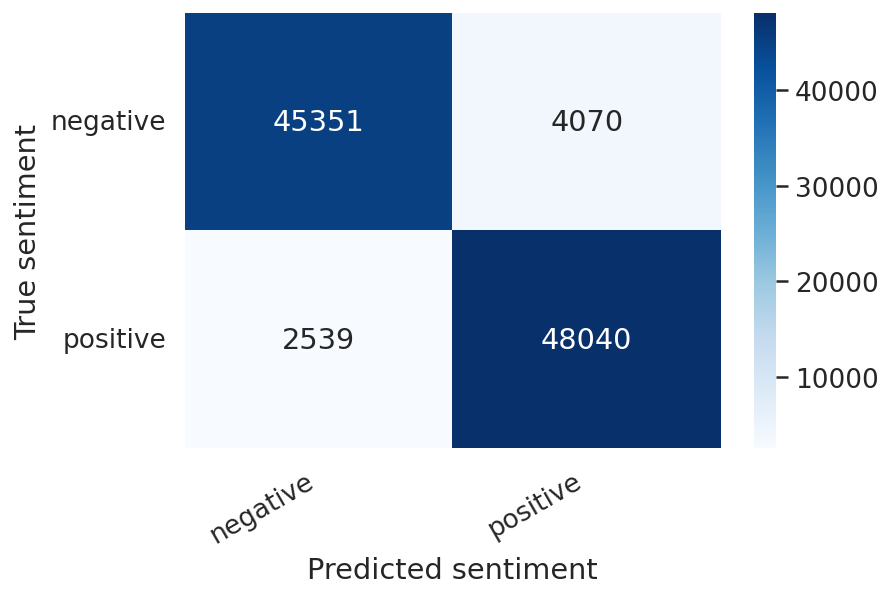

In [44]:
from sklearn.metrics import confusion_matrix

def show_confusion_matrix(confusion_matrix):
  hmap = sns.heatmap(confusion_matrix, annot=True, fmt="d", cmap="Blues")
  hmap.yaxis.set_ticklabels(hmap.yaxis.get_ticklabels(), rotation=0, ha='right')
  hmap.xaxis.set_ticklabels(hmap.xaxis.get_ticklabels(), rotation=30, ha='right')
  plt.ylabel('True sentiment')
  plt.xlabel('Predicted sentiment');

cm = confusion_matrix(y_test, y_pred)
df_cm = pd.DataFrame(cm, index=['negative', 'positive'], columns=['negative', 'positive'])
show_confusion_matrix(df_cm)

#### Predictions

In [54]:
review_text = "I hate completing my todos! "

In [55]:
encoded_review = tokenizer.encode_plus(
  review_text,
  max_length=MAX_LEN,
  add_special_tokens=True,
  return_token_type_ids=False,
  pad_to_max_length=True,
  return_attention_mask=True,
  return_tensors='pt',
)

In [56]:
class_names = ['negative', 'positive']
input_ids = encoded_review['input_ids'].to(device)
attention_mask = encoded_review['attention_mask'].to(device)

output = review_classifier(input_ids, attention_mask)
_, prediction = torch.max(output, dim=1)

print(f'Review text: {review_text}')
print(f'Sentiment  : {class_names[prediction]}')

Review text: I hate completing my todos! 
Sentiment  : negative
